# SIMBA: Inference Notebook

This notebook demonstrates how to run inference using **SIMBA** (Spectral Identification of Molecule Bio-Analogues), a deep learning model designed to predict structural similarity between pairs of MS/MS spectra.


### What this notebook covers:
- **Loading the trained SIMBA model** and required libraries
- **Preprocessing MS/MS spectra**: normalizing, cleaning, and formatting inputs
- **Running the model** to obtain similarity predictions between spectral pairs
- **Visualizing results**, including substructure edit distance and MCES predictions

### Requirements:
- Trained SIMBA model checkpoint
- Mass spectrometry input data (e.g., as .mgf or .mzML files, or as processed arrays)
- Dependencies listed in the project repository

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from simba.config import Config
from simba.simba.simba import Simba
from simba.simba.preprocessing_simba import PreprocessingSimba
from simba.simba.plotting import Plotting
from simba.simba.analog_discovery import AnalogDiscovery
import numpy as np
import spectrum_utils.plot as sup
from rdkit import Chem


Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


* In this notebook, we load spectra from a mgf file and this is run on SIMBA to produce the corresponding edit distance and mces distances

In [3]:
config=Config()
config.USE_LEARNABLE_MULTITASK=True

In [4]:
model_location = '/Users/sebas/projects/data/best_model_20250422_only_massspecgym.ckpt'
mgf_file = '/Users/sebas/projects/data/ALL_GNPS_NO_PROPOGATED_wb.mgf'
casmi_file= '/Users/sebas/projects/data/processed_massformer/spec_df.pkl' 

## Initialize Simba

In [5]:
simba= Simba(model_location, config=config, device='cpu', cache_embeddings=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sebas/miniconda3/envs/simba/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/sebas/miniconda3/envs/simba/lib/python3.11/site-packages/lightning/pytorch/core/saving.py:177: Found keys that are not in the model state dict but in the checkpoint: ['log_sigma1', 'log_sigma2']


## load mgf file

In [6]:
all_spectrums=PreprocessingSimba.load_spectra(casmi_file, config, use_gnps_format=False)

/Users/sebas/projects/data/processed_massformer/spec_df.pkl


In [7]:
len(all_spectrums)

158

Let's take 400=20x20 random pairs and calculate the similarities.

In [8]:
np.random.seed(42)
random_indexes_0= np.random.randint(0,len(all_spectrums),20)
random_indexes_1= np.random.randint(0,len(all_spectrums),20)

In [9]:
## spectrums of the first index
import copy
all_spectrums_0 = copy.deepcopy([all_spectrums[index] for index in random_indexes_0])
all_spectrums_1 = copy.deepcopy([all_spectrums[index] for index in random_indexes_1])

In [10]:
len(all_spectrums_0)

20

## Predictions

In [11]:
sim_ed, sim_mces= simba.predict(all_spectrums_0, all_spectrums_1)

Preprocessing all the data ...


20it [00:00, 21236.98it/s]


Finished preprocessing 
loading data
Normalizing intensities
Preprocessing all the data ...


20it [00:00, 38836.15it/s]
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finished preprocessing 
loading data
Normalizing intensities
running
Processing embeddings ...


/Users/sebas/miniconda3/envs/simba/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/sebas/miniconda3/envs/simba/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

/Users/sebas/projects/metabolomics/simba/transformers/spectrum_transformer_encoder_custom.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mass_precursor = torch.tensor(kwargs["precursor_mass"].float())
/Users/sebas/projects/metabolomics/simba/transformers/spectrum_transformer_encoder_custom.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  charge_precursor = torch.tensor(kwargs["precursor_charge"].float())
/Users/sebas/miniconda3/envs/simba/lib/python3.11/site-packages/torch/nn/modules/transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten

running
Processing embeddings ...


Predicting: |                                                                                                 …

/Users/sebas/miniconda3/envs/simba/lib/python3.11/site-packages/lightning/pytorch/core/saving.py:177: Found keys that are not in the model state dict but in the checkpoint: ['log_sigma1', 'log_sigma2']
20it [00:00, 4430.45it/s]

Elapsed time: 0.10 seconds


## Ground truth

In [12]:
from simba.simba.ground_truth import GroundTruth

In [13]:
ground_truth_ed=GroundTruth.compute_edit_distance(all_spectrums_0, all_spectrums_1)

In [14]:
import myopic_mces

In [15]:
ground_truth_mces=GroundTruth.compute_mces(all_spectrums_0, all_spectrums_1)

Running myopic ...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sebas/miniconda3/envs/simba/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/4x/y1dnj1n55js4gtv69lsx4g4h0000gn/T/b7ef5eb970b4435bbb85f146aa62f3c0-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/4x/y1dnj1n55js4gtv69lsx4g4h0000gn/T/b7ef5eb970b4435bbb85f146aa62f3c0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1284 COLUMNS
At line 7567 RHS
At line 8847 BOUNDS
At line 9613 ENDATA
Problem MODEL has 1279 rows, 765 columns and 4654 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 17.9971 - 0.08 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 23 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 23 strengthened rows, 0 substitutions
Cgl0004I processed model has 807 rows, 765 columns (765 integer (76

(array([  4.,   5.,  71., 165.,  81.,  43.,  17.,   8.,   4.,   2.]),
 array([ 0. ,  5.9, 11.8, 17.7, 23.6, 29.5, 35.4, 41.3, 47.2, 53.1, 59. ]),
 <BarContainer object of 10 artists>)

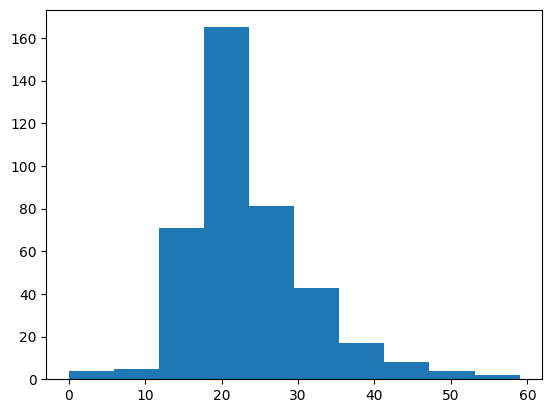

In [16]:
import matplotlib.pyplot as plt
plt.hist(np.reshape(ground_truth_mces,-1))

## Comparison between predictions and ground truth

In [17]:
from scipy.stats import spearmanr

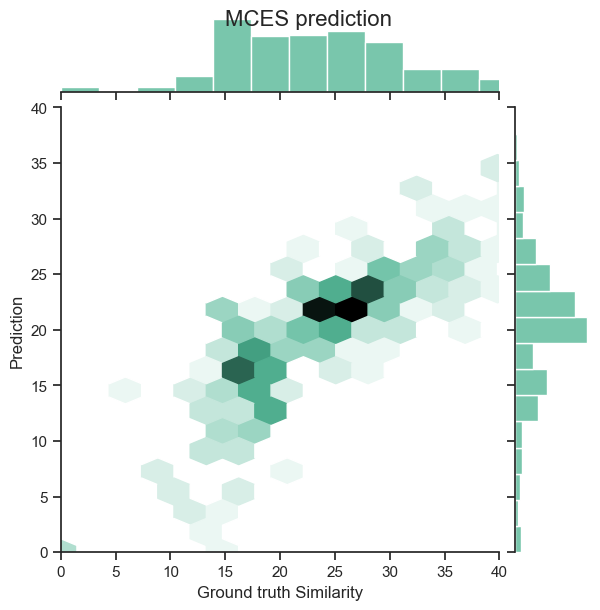

In [18]:
Plotting.plot_mces(np.reshape(ground_truth_mces,-1), np.reshape(sim_mces,-1))

Confusion matrix per sample:
[[266  61  26  17   5   5]
 [  0   2   1   2   1   0]
 [  0   1   4   1   0   0]
 [  0   1   0   3   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   1   0   3]]
Accuracy: 0.695
[[0.7        0.16052632 0.06842105 0.04473684 0.01315789 0.01315789]
 [0.         0.33333333 0.16666667 0.33333333 0.16666667 0.        ]
 [0.         0.16666667 0.66666667 0.16666667 0.         0.        ]
 [0.         0.25       0.         0.75       0.         0.        ]
 [       nan        nan        nan        nan        nan        nan]
 [0.         0.         0.         0.25       0.         0.75      ]]


/Users/sebas/projects/metabolomics/simba/simba/plotting.py:56: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]


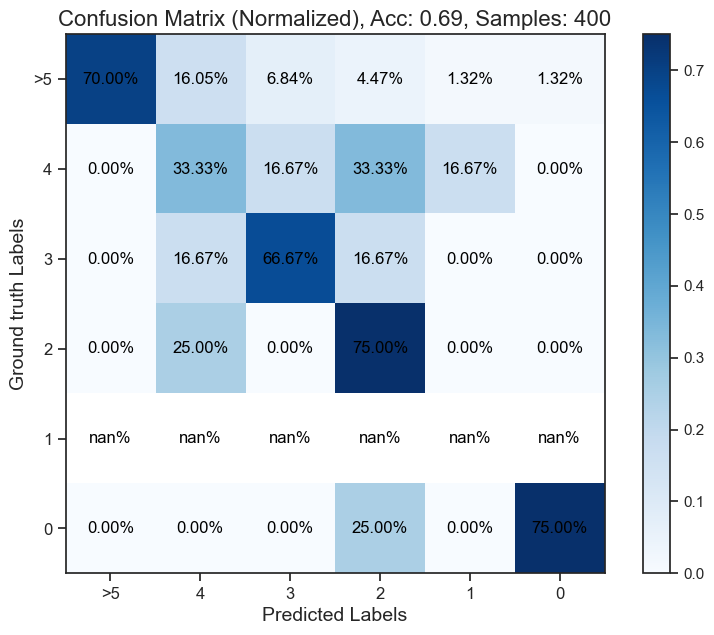

In [19]:
Plotting.plot_cm(true=ground_truth_ed, preds=sim_ed)

## Check the closest spectra

* It returns a ranking matrix where if the score is higher, the similarity is higher based on reranking of MCES and Edit distance 

In [20]:

ranking= AnalogDiscovery.compute_ranking(sim_mces, sim_ed)

## Plot the closest spectra

In [21]:
target_index=9

In [22]:
best_match_index= np.argmax(ranking[target_index])


* Ground truth

In [23]:
print(f'Edit distance {ground_truth_ed[target_index, best_match_index]}, MCES distance {ground_truth_mces[target_index, best_match_index]}')

Edit distance 5.0, MCES distance 16.0


* Prediction

In [24]:
print(f'Edit distance {sim_ed[target_index, best_match_index]}, MCES distance {sim_mces[target_index, best_match_index]}')

Edit distance 4, MCES distance 13.339416980743408


In [25]:
spectra_0= all_spectrums_0[target_index]

In [26]:
spectra_1= all_spectrums_1[best_match_index]

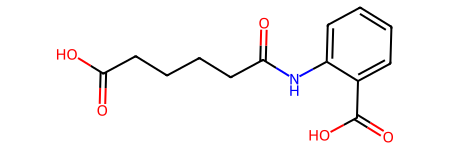

In [27]:
Chem.MolFromSmiles(spectra_0.params['smiles'])

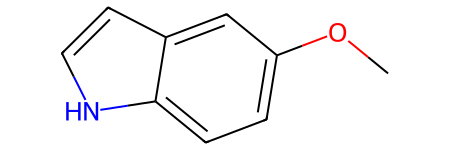

In [28]:
Chem.MolFromSmiles(spectra_1.params['smiles'])

In [29]:
spectra_0.params

{'spectrumid': '307 M+H',
 'name': '307 M+H',
 'inchi': '',
 'organism': 'casmi',
 'id': 307,
 'smiles': 'O=C(O)CCCCC(=O)Nc1ccccc1C(=O)O',
 'ionmode': 'Positive',
 'pepmass': [266.102037994695],
 'charge': [1],
 'libraryquality': 1}

In [30]:
spectra_1.params

{'spectrumid': '226 M+H',
 'name': '226 M+H',
 'inchi': '',
 'organism': 'casmi',
 'id': 226,
 'smiles': 'COc1ccc2[nH]ccc2c1',
 'ionmode': 'Positive',
 'pepmass': [148.075452106098],
 'charge': [1],
 'libraryquality': 1}

<Axes: xlabel='m/z', ylabel='Intensity'>

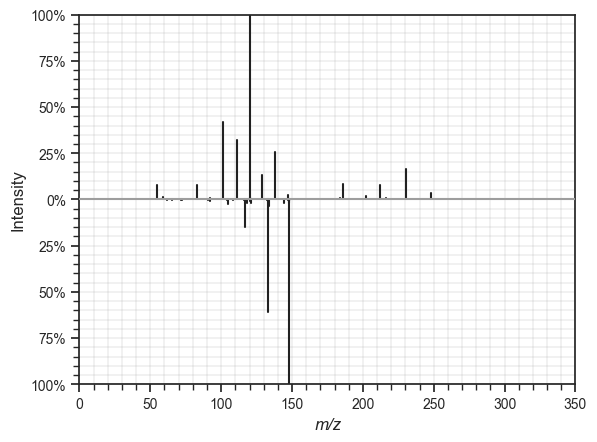

In [31]:
sup.mirror(spectra_0, spectra_1)